## Source separation example using sGMCA
F. Acero,R. Carloni, J. Bobin, October 2022  
Ref: Semi-Blind Source Separation with Learned Constraints. Carloni-Gertosio et al. 2023  [PDF](https://www.sciencedirect.com/science/article/pii/S0165168422003152)

This notebook shows an example of blind source separation on real X-ray data cubes.  
The semi-blind source separation requires a learnt model with the IAE which will be presented in another notebook.  
The GMCA version presented here is available and described in more details at :  
https://github.com/RCarloniGertosio/sGMCA

The current notebook makes use of `gammapy` and `numba` (optional) packages.  
If installing `gammapy` on a M1, you can decomment the sherpa package in the env yaml installation file.



In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, fixed


from sgmca_FA import sgmca, reconstruct_comp
import starlet2d
#import pyregion #for creating masks from ds9 region. Conda install pyregion if needed


from astropy.visualization import simple_norm
from astropy.io import fits
from astropy import wcs
from astropy.convolution import convolve,convolve_fft, Gaussian2DKernel
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.nddata import Cutout2D

plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'CMRmap_r'


In [8]:

def plot_comp_spectrum(k,spectrum,image_source,smooth=False,cmap='CMRmap_r',log=True,
                       save=False,savefig=False,sign=1,spec_ref=None,scale='sqrt'):
                      
    """
    Plotting the outputs of GMCA
    Best-used in an interact ipywidget in jupyter notebooks
    """
    
    image_=image_source[k,:,:]
    
    if smooth:
        kernel = Gaussian2DKernel(x_stddev=1)
        image_ = convolve_fft(image_,kernel)

    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6), gridspec_kw = {'wspace':0.23, 'hspace':0} )
        
    p1=ax1.imshow(sign*image_,aspect=1.,
                  cmap=cmap,norm=simple_norm(sign*image_, scale,min_cut=0),origin='lower'  )
    ax1.ticklabel_format(useOffset=False)
    cbar=plt.colorbar(p1,fraction=0.045,ax=ax1,spacing='uniform') #,format='%.1e'

    ax1.axis('off')

    if Eref.shape != spectrum[k].shape:
        E_ = np.arange(spectrum[k].shape[0])
    else :
        E_ = Eref
    renorm=0 #to minimize impact of negative values in y-log
    ax2.plot(E_,spectrum[k]+renorm,lw=1.5,linestyle='-',antialiased=False,label='Retrieved spectrum')        
    ax2.plot(E_,spec+renorm,ls='-',lw=2,label='Observed spectrum',color='k')
    if spec_ref is not None: ax2.plot(E_, spec_ref,ls='-',lw=1,label='Spectral reference',color='dimgrey')


    ax2.set_xlim(E_.min()+0.05,E_.max())
    ax2.set_ylim(1e2,spec.max()*5)


    ax2.set_xlabel('Energy (keV)',fontsize=13)
    ax2.set_ylabel('Counts',fontsize=13)
    plt.legend()
    
    plt.suptitle(f'{prefix}_Ncomp{k}')

    if log:
        ax2.set_yscale('log')
        maxval=np.max(spec)
        ax2.set_ylim(maxval*1e-5,maxval*5)

    if save:
        outfile='../components_output/%s_comp%i.fits'%(name,k)
        fits.writeto(outfile,image_, header=w.to_header(),overwrite=True)
        print('File saved to : %s'%(outfile))
    if savefig:
#        outfile='../components_output/%s_Comp%i.pdf'%("_".join(cube_file.split('/')[-1].split('_')[1:])[:-5], k)
        outfile='../components_output/%s_Comp%i.pdf'%(prefix, k)
        plt.savefig(outfile)
        print('File saved to : %s'%(outfile))
        

    plt.show()
    
    

def plot_sum(E,cube_data,spectrum,log=False):

    """
    Compare the observerd spectrum with the components and their sum
    """
    plt.plot(E,cube_data.sum(axis=(1,2)),color='k',label='Data')
    for i,sp in enumerate(spectrum):
        plt.plot(E,sp,label=f'Component {i+1}')
    plt.plot(E,spectrum.sum(axis=0),color='k',ls=':',label='Sum')
    plt.legend()
    ratio = spectrum.sum(axis=(0,1)) / cube_data.sum(axis=(0,1,2))
    plt.title(f' ratio comp/data = {ratio:.4f}')
    plt.xlabel('Energy (keV)',fontsize=13)
    plt.ylabel('Counts',fontsize=13)
    if log:
        plt.yscale('log')
        plt.ylim(spec.max()*1e-3, spec.max()*3)
        
        


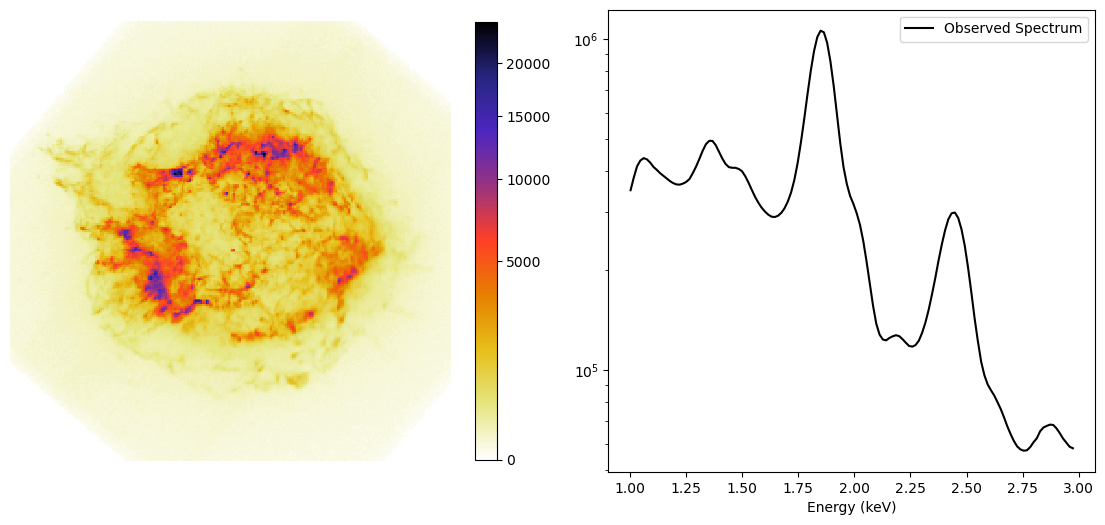

In [12]:
cube_file='data/Cube_CasA_239pix_XYrebin4_Erebin1_obs4638.FTZ'

#Select an energy range to slice the data cube
E1=1 #in keV
E2=3



cube_data=np.asarray(fits.getdata(cube_file),dtype='float32' )
header=fits.getheader(cube_file)


# If you want to mask point sources in the data cube
#regfile="M87-BCG2-mask.reg"
#import pyregion
#regions = pyregion.open(regfile)
#mask=np.invert(regions.get_mask(header=header,shape=(cube_data.shape[1],cube_data.shape[2]) ) )
#cube_data *= mask


#from gammapy.maps import WcsGeom, WcsNDMap
#m = WcsNDMap.read(cube_file)
#Eref_ = m.geom.axes[0].center.value  


# energy axis if not a gammapy created cube.
E = 0.010 + 14.6e-3*np.arange(1024)
Eref = E

name =cube_file.split('/')[-1][:-4]

#Slicing the data cube to selected energy range.
i1=np.abs(E - E1).argmin() ; i2=np.abs(E - E2).argmin()
Eref=Eref_[i1:i2-1]
cube_data=cube_data[i1:i2-1,:,:]

w = wcs.WCS(header).celestial # To keep only SKy info not Energy binning


spec=np.sum(cube_data,axis=(1,2))
im=cube_data.sum(axis=0)



fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6), gridspec_kw = {'wspace':0.23, 'hspace':0} )

p1=ax1.imshow(im,aspect=1.,norm=simple_norm(im, 'sqrt',min_cut=0),origin='lower'  )
ax1.ticklabel_format(useOffset=False)
cbar=plt.colorbar(p1,fraction=0.045,ax=ax1,spacing='uniform') #,format='%.1e'
ax2.plot(Eref,spec,c='k',label='Observed Spectrum')
ax2.set_yscale('log')
ax2.set_xlabel('Energy (keV)')
plt.legend()
ax1.axis('off')
plt.show()


# Run sGMCA

In [5]:

#Number of components 
Ncomp=4 
#Noise thresholding in the GMCA iterations. The higher the smoother the output image and faint components might not be found. Typically between 0.5-3 values
kthresh=1
#Number of wavelet scales used. Typically 1-4 values. Larger imaging can benefit from more wavelet scales
nscales=3

name =cube_file.split('/')[-1][:-4]
prefix=f'{name}_Ncomp{Ncomp}_nscales{nscales}_kthr{kthresh}'

#reshaping the data cube to a vector
X=cube_data.reshape(cube_data.shape[0],cube_data.shape[1]*cube_data.shape[2])

#Performing the GMCA analysis
#The goal is to solve X = A*S 
#where X is 3D data cube of size (Nx, Ny, Nz), A the retrieved spectra (Ncomp,Nz) , S the associated images (Ncomp,Nx,Ny)
A, Sources=sgmca(X, n=Ncomp, nscales=nscales, verb=2,k=kthresh,
                   nbItMax1=500, eps=[1e-5], doSemiblind=False,models=None)

Iteration # 1
delta_S = 1.00e+00 - delta_A = 2.61e-01 - cond(A) = 2.81
Iteration # 11
delta_S = 4.81e-02 - delta_A = 9.59e-04 - cond(A) = 7.75
Iteration # 21
delta_S = 1.17e-02 - delta_A = 1.52e-04 - cond(A) = 6.49
Iteration # 31
delta_S = 6.54e-03 - delta_A = 2.31e-05 - cond(A) = 6.36
Iteration # 41
delta_S = 5.35e-03 - delta_A = 2.82e-05 - cond(A) = 6.31
Iteration # 51
delta_S = 5.15e-03 - delta_A = 6.25e-05 - cond(A) = 6.30
Iteration # 61
delta_S = 6.43e-03 - delta_A = 4.99e-05 - cond(A) = 6.27
Iteration # 71
delta_S = 7.21e-03 - delta_A = 2.53e-05 - cond(A) = 6.15
Iteration # 81
delta_S = 7.53e-03 - delta_A = 1.31e-05 - cond(A) = 5.95
Iteration # 91
delta_S = 8.10e-03 - delta_A = 1.98e-05 - cond(A) = 5.69
Iteration # 101
delta_S = 5.62e-03 - delta_A = 1.68e-05 - cond(A) = 5.43
Iteration # 111
delta_S = 1.63e-03 - delta_A = 1.68e-06 - cond(A) = 5.28
Iteration # 121
delta_S = 1.26e-03 - delta_A = 1.07e-06 - cond(A) = 5.17
Iteration # 131
delta_S = 1.09e-03 - delta_A = 8.61e-07 - cond

## Plotting the decomposition results

In [10]:
Sources=Sources.reshape(Sources.shape[0],cube_data.shape[1],cube_data.shape[2])
spectrum, image_source = reconstruct_comp(Sources,A)

BKGnorm=1

interact(plot_comp_spectrum,image_source=fixed(image_source),
         spectrum=fixed(spectrum),
         spec_tot=fixed(cube_data.sum(axis=(1,2))),
         k=(0,image_source.shape[0]-1,1),
         spec_ref=fixed(None),
         vmax=fixed(0),
         scale=['linear', 'sqrt','log']) 


interactive(children=(IntSlider(value=1, description='k', max=3), Checkbox(value=False, description='smooth'),…

<function __main__.plot_comp_spectrum(k, spectrum, image_source, smooth=False, cmap='CMRmap_r', log=True, save=False, savefig=False, sign=1, spec_ref=None, scale='sqrt')>

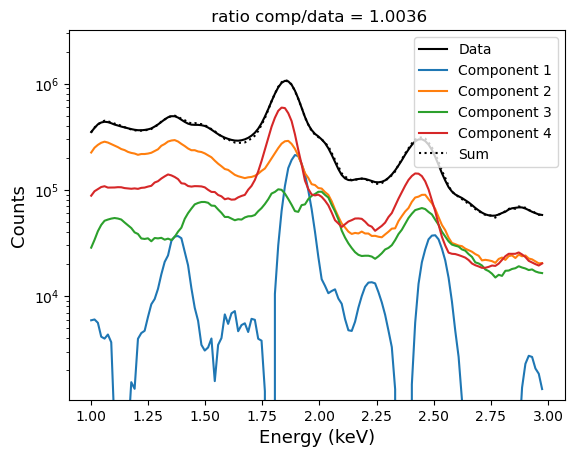

In [11]:
plot_sum(Eref,cube_data,spectrum,log=True)